# Health Insurance Cross-Sell
---

Neste trabalho, estamos lidando com uma empresa que fornece seguros de saúde para os seus assegurados. Todos pagam um valor anual para ter direito ao seguro. O time de produto está querendo lançar um novo produto, que é um seguro de carro, entretanto, antes de lançar, eles querem saber se isto é viável e o quanto isto daria de dinheiro e para quem deveriam oferecer. Para solucionar isso, a equipe fez uma pesquisa entre seus assegurados perguntando se estas pessoas comprariam um seguro de automóvel ou não. Unindo as características que já se tem do cliente com a resposta de "sim" ou "não", é necessário tentar prever qual seria a resposta de pessoas que não participaram da pesquisa. O papel do cientista de dados é, a partir da base de dados que foi respondida, treinar um classificador para então saber se as pessoas novas comprariam um seguro de automóvel ou não.

Existe uma limitação no problema, para fazer esta campanha, existe um limite de pessoas, foi definido pelo time de produtos que seria feito por contato direto, ou seja, ligação telefónica. Basicamente, o time de produtos vai passar uma lista para o time de comercial, que vai ligar para as pessoas e vai oferecer o seguro de automóvel. Entretanto, o time comercial tem um limite de apenas 2 mil ligações, então, entre as 127 mil pessoas que podem receber, precisamos construir uma lista priorizando as 2 mil pessoas com mais chances de conseguir que comprem o seguro. 

# 0.0 Imports
---

In [158]:
import pickle
import random
import warnings

import numpy             as np
import pandas            as pd
import seaborn           as sns
import xgboost           as xgb
import psycopg2          as pg
import matplotlib.pyplot as plt
import scikitplot        as skplt

from sklearn.model_selection import StratifiedKFold

from scipy   import stats           as ss
from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import tree            as tr
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm

## 0.1 Helper Functions
---

In [159]:
# ignore warnings
warnings.filterwarnings('ignore')

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()

    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm ) [0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( (kcorr-1) , (rcorr-1) ) ) )


def cross_validation(kfold, at_k, model, data,target,cols_selected):
    
    folds = ms.StratifiedKFold(n_splits=kfold,shuffle=True,random_state=42)
    
    precision = []
    recall = []
    
    for train_index, test_index in folds.split(data,data[target]):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        #train and test model - return model probas
        yhat_model = model_evaluation(train,test,model,cols_selected,target)
        
        df_score = test.copy()
        df_score['score'] = yhat_model[:,1].tolist()
        df_score = df_score.sort_values('score',ascending=False)
        
        precision_model = precision_at_k(df_score,at_k)
        recall_model = recall_at_k(df_score,at_k)
        
        precision.append(precision_model)
        recall.append(recall_model)

    mean_p = np.mean(precision)
    std_p = np.std(precision)
    
    mean_r = np.mean(recall)
    std_r = np.std(recall)
    
    return mean_p, std_p, mean_r, std_r

def model_evaluation(train,test,model,cols_selected,target):
    x_train = train[cols_selected]
    y_train = train[target]
    
    x_test = test[cols_selected]
    
    model.fit(x_train,y_train)
    
    yhat_model = model.predict_proba(x_test)
    
    return yhat_model

def precision_at_k(data, k=5000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1

    #computing precision at k score
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    precision_at_k = data.loc[k,'precision_at_k']
    
    return precision_at_k


def recall_at_k(data, k=5000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1

    #computing recall at k score
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
    recall_at_k = data.loc[k,'recall_at_k']
    
    return recall_at_k


## 0.1 Loading Data
---

In [160]:
# read file with password
file = open('C:/Users/ASPIREB E15/Downloads/Data Science/Health Insurance Cross Sell/notebooks/db_insurance.txt', 'r')

# Creadentials
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
PASSWORD = file.read()


try: # Connect DB
    conn = pg.connect(
        host=host,port=port, database=database, user=username, password=PASSWORD
    )
    
    # Query data
    query = """
        SELECT *
        FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id = v.id)
                           LEFT JOIN pa004.insurance i on (u.id = i.id)  
    """
    
    # Read in sql and parse to Dataframe
    df_raw = pd.read_sql(query, conn)
    df_raw = df_raw.drop(df_raw.columns[[5]], axis=1)
    df_raw['id'] = list(df_raw.index)
    conn.close()
    
except Exception as e: # Connection Error  
    print("Database connection failed due to {}".format(e))

df_raw.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,id
0,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0,0
1,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0,1
2,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0,2
3,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0,3
4,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0,4


# 1.0 Data Description
---

In [161]:
df1 = df_raw.copy()

## 1.1 Data Dimension
---

In [162]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 1.2 Data Types
---

In [163]:
df1.dtypes

gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
id                        int64
dtype: object

## 1.3 Check NA
---

In [164]:
df1.isna().sum()

gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
id                      0
dtype: int64

## 1.4 Data Descriptive
---

In [165]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.4.1 Variáveis numéricas
---

In [166]:
# Calculate kurtosis and skew
kurtosis = num_attributes.apply(lambda x: x.skew())
skew = num_attributes.apply(lambda x: x.kurtosis())

# Describe data
describe = num_attributes.describe().T

# Add skew and kurtosis in describe
describe['skew'] = skew
describe['kurtosis'] = kurtosis

# Show describe
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,6.725390e-01
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-1.152664e-01
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-9.000081e-01
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-2.159518e+01
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,1.677471e-01
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087e+00
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,3.029517e-03
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906e+00
id,381109.0,190554.000000,110016.836208,0.0,95277.0,190554.0,285831.0,381108.0,-1.200000,9.443274e-16


In [167]:
df1['previously_insured'].value_counts(normalize=True)

0    0.54179
1    0.45821
Name: previously_insured, dtype: float64

In [168]:
len(df1['policy_sales_channel'].unique())

155

#### **Principais Pontos:**
---
Os dados não parecem ter incosistências.
- Os clientes possuem idade média de 38 anos
- A idade dos clientes variam de 20 até 85 anos
- 54% dos clientes que responderam as perguntas já tem um seguro veicular
- Existem 155 canais diferentes de comunicação com a Insurance All
- Em média, os clientes pagaram 30k para obter o seguro
- O valor máximo de um seguro foi de 540k
- Em média, os clientes entraram faz 154 dias na empresa.
- O cliente mais recente possui 10 dias na empresa.
- 75% das pessoas não tem interesse em comprar um seguro de automóvel


### 1.4.2 Variáveis Categóricas
---

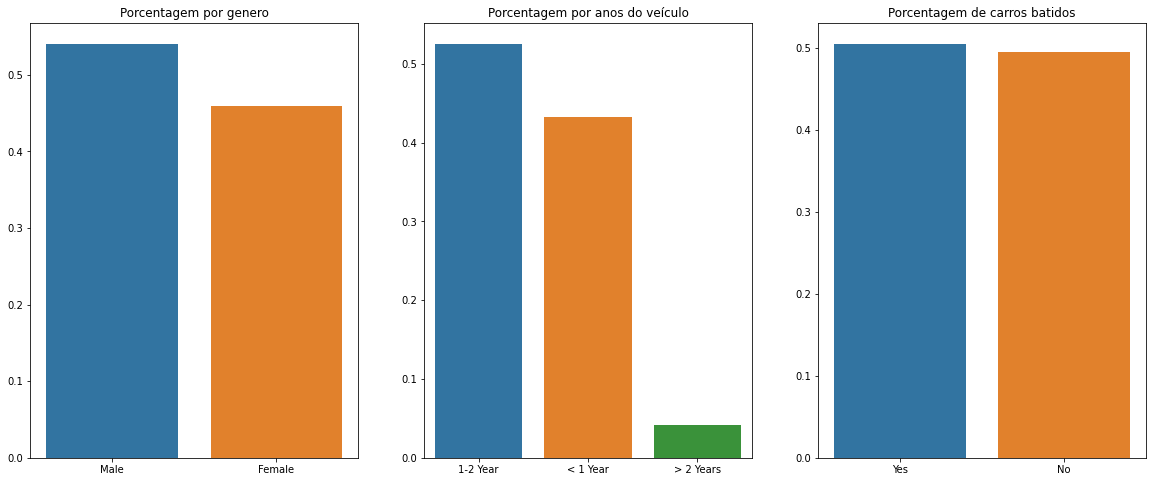

In [169]:
gender = cat_attributes['gender'].value_counts(normalize=True)
vehicle_age = cat_attributes['vehicle_age'].value_counts(normalize=True)
vehicle_damage = cat_attributes['vehicle_damage'].value_counts(normalize=True)

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x=gender.index, y = gender.values).set(title='Porcentagem por genero');

plt.subplot(1,3,2)
sns.barplot(x=vehicle_age.index, y = vehicle_age.values).set(title='Porcentagem por anos do veículo');

plt.subplot(1,3,3)
sns.barplot(x=vehicle_damage.index, y = vehicle_damage.values).set(title='Porcentagem de carros batidos');

#### Principais Pontos:
---
- A maior parte dos assegurados são homens, um total de aproximadamente 55%
- Apenas 5% dos carros tem mais de 2 anos
- A maioria dos carros estão entre 1 e 2 anos
- A quantidade de motoristas que bateram o carro é quase igual a quantidade que não bateu

# 2.0 Feature Engineering
---

## 2.1 Lista de Hipóteses
---

**1.** Usuários com automóveis com menos de um ano de uso possuem menos interesse em contratar um seguro.

**2.** A maioria dos usuários que querem um seguro de saúdo são mulheres.

**3.** Usuários com idade maior que 40, estão interessadas em contratar um seguro.

**4.** A maioria dos usuários que tiveram um acidente veicular não querem seguro de saúde.

**5.** Usuários que não possuem CNH, não estão mais interessadas em contratar um seguro.

**6.** Clientes com seguros automotivos são mais propensos a quererem seguro de saúde.

## 2.2 Feature Engineering
---

In [170]:
df2 = df1.copy()

In [171]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years'     if x == '> 2 Years' else 
                                                        'between_1_2_year' if x == '1-2 Year'  else 'below_1_year')

# age_category: over 40 years old or under and equal 40 years old.
df2['age_category'] = df2['age'].apply(lambda x: 'over_40_years' if x > 40 else 'under_40_years')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Data Filtering
---

In [172]:
df3 = df2.copy()

Como não há dados muito discrepantes, como pode ser visto na etapa 1.4, então, a princípio, não será feito nenhum filtro.

# 4.0 Exploratory Data Analysis
---

In [173]:
df4 = df3.copy()

## 4.1 Análise Univariada

In [174]:
df4.columns

Index(['gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response', 'id',
       'age_category'],
      dtype='object')

### age

<AxesSubplot:xlabel='response', ylabel='age'>

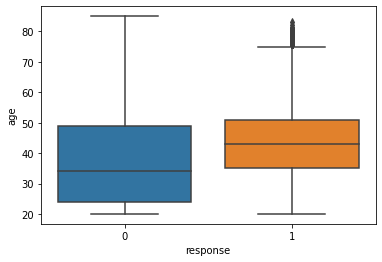

In [175]:
sns.boxplot(x='response', y='age', data=df4)

Para o grupo de pessoas que não estão interessadas (0), a mediana é de mais ou menos 35 anos, do primeiro ao terceiro quartil há uma  variáção de 25 a 50 anos. Já as pessoas interessadas no produto (1), a mediana de idades é maior, os primeiros e terceiros quartis são maiores também. 

Esta variável pode ser interessante para o modelo, pois indicam que pessoas mais novas não tem tanto interesse em seguros de vida, o que faz sentido.

<AxesSubplot:xlabel='age', ylabel='Count'>

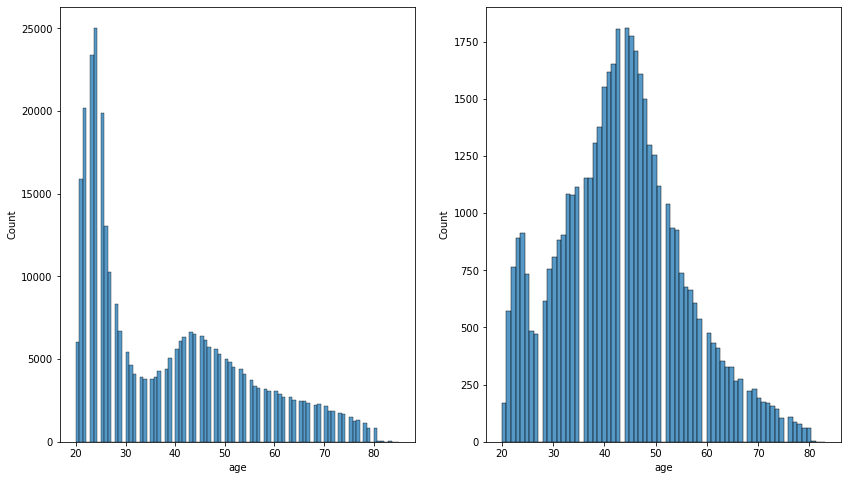

In [176]:
plt.figure(figsize=(14, 8))
plt.subplot(1,2,1)
aux00 = df4.loc[df4['response'] == 0,'age']
sns.histplot(aux00)

plt.subplot(1,2,2)
aux01 = df4.loc[df4['response'] == 1,'age']
sns.histplot(aux01)

Existe uma concentração muito grande de pessoas sem interesse para age próximo de 20. Já para o histograma de pessoas com interesse, a maioria das idades estão entre 40 e 50 anos. Um ponto a ser observado é que há um possível desbalanceamento das variáveis, existe muito mais dados com "não" do que com "sim". Este ponto será melhor analisado mais a frente.

### anual_premium

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

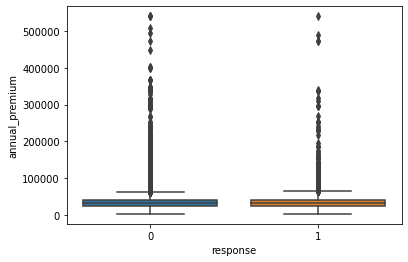

In [177]:
sns.boxplot(x='response', y='annual_premium', data=df4)

Como não é possível observar nada devido ao excesso de outliers, será analisado um corte nos dados para valores menores que 80000.

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

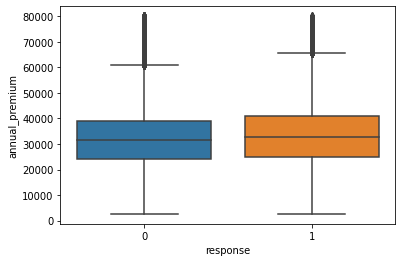

In [178]:
aux = df4[df4['annual_premium']<80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

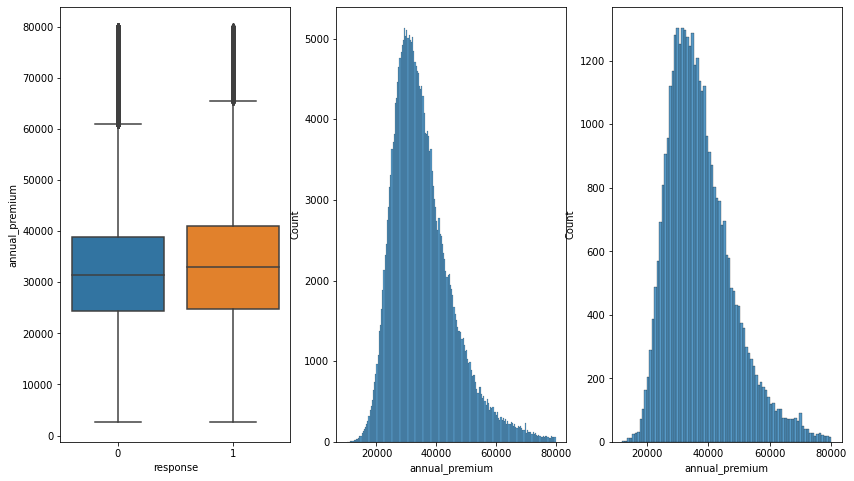

In [179]:
plt.figure(figsize=(14, 8))

plt.subplot(1,3,1)
aux = df4[df4['annual_premium']<80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

plt.subplot(1,3,2)
aux2 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium']<80000)]
aux00 = aux2.loc[aux2['response'] == 0,'annual_premium']
sns.histplot(aux00)

plt.subplot(1,3,3)
aux01 = aux2.loc[aux2['response'] == 1,'annual_premium']
sns.histplot(aux01)

Como são muito parecidas, é bem provável que não ajude a resolver o problema aqui, uma vez que não há uma separação entre as classes

### driving_license

<AxesSubplot:xlabel='response', ylabel='driving_license'>

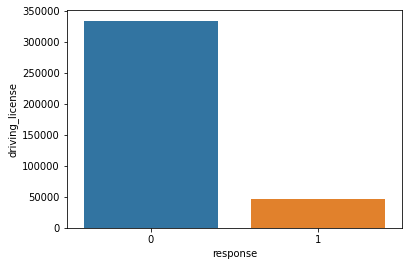

In [180]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux)

Muito mais pessoas que dirigem e não querem fazer o seguro de carro.

In [181]:
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


Ou seja, 87% das pessoas que dirigem não querem fazer o seguro e 12% dos que dirigem querem fazer seguro.

### region_code

In [182]:
df4[['region_code', 'response']].head()

,region_code,response
0,11.0,0
1,15.0,0
2,35.0,0
3,8.0,0
4,8.0,0


<AxesSubplot:xlabel='region_code', ylabel='id'>

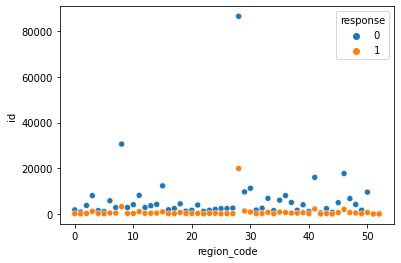

In [183]:
aux0 = df4[['id','region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

É possível observar o region_code 29, onde aproximadamente 80000 mil pessoas não estão interessadas em assinar o produto, enquanto 20000 estão interessadas. Nesta situação, é possível afirmar que há uma discriminação entre os dados, ou seja, é possível fazer uma separação clara entre as duas regiões. Entretanto, para todos os outros pontos há uma mistura entre 0 e 1. Então, analisando esta variável separadamente, não é interessante para o modelo.

### previously_insured

In [184]:
df4[['previously_insured', 'response']].head()

,previously_insured,response
0,0,0
1,1,0
2,1,0
3,0,0
4,0,0


In [185]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


A combinação (0,0) indica pessoas que não tinham seguro anteriormente e que também não querem este novo produto, 77% dos dados responderam esta alternativa. Para pessoas que anteriormente não tinham seguro e responderam que queriam o produto (0,1) foi de 22%. Das pessoas que já tinham seguro e não querem (1,0) foi de 99% e das que tem seguro e querem este novo produto, quase 0%. 

Vale salientar que aqui está sendo considerado pessoas que já tem um seguro de saúde anterior, então, faz sentido a porcentagem ser baixa. 

### vehicle_age

In [186]:
df4[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()

,vehicle_age,response,0
0,below_1_year,0,0.413488
1,below_1_year,1,0.018897
2,between_1_2_year,0,0.434285
3,between_1_2_year,1,0.091328
4,over_2_years,0,0.029663
5,over_2_years,1,0.012338


Então, pessoas com carros com idade abaixo de 1 anos, 41% responderam não querer seguro, enquanto 1,8% respondeu que querem. O mesmo se segue para as outras variáveis, uma taxa de rejeição muito alta, exceto para situação em que os carros tem mais de 2 anos. A princípio, a situação em que há uma discriminação dos valores mais clara ajude o modelo, entretanto, é necessário ver o efeito na hora de implementar mais a frente.

### vintage

<AxesSubplot:xlabel='response', ylabel='vintage'>

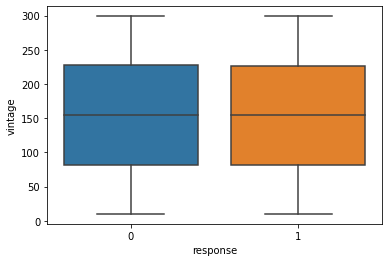

In [187]:
sns.boxplot(x='response', y='vintage', data=df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

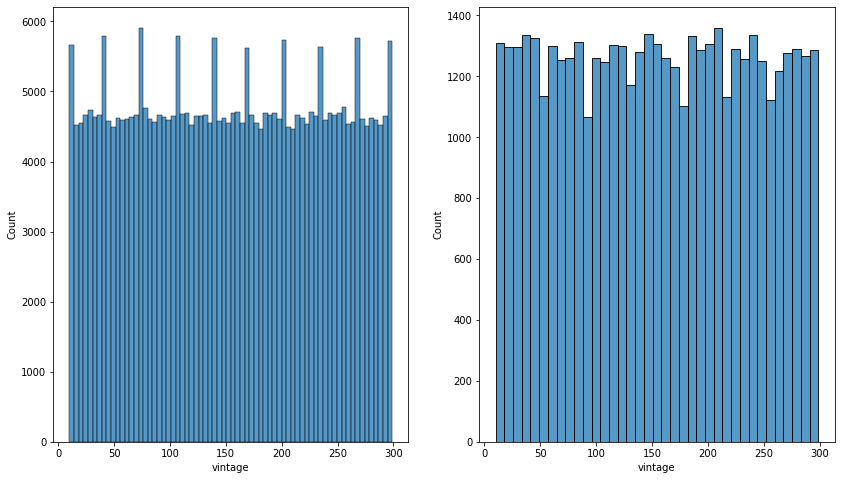

In [188]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
aux00 = df4.loc[df4['response'] == 0,'vintage']
sns.histplot(aux00)

plt.subplot(1,2,2)
aux01 = df4.loc[df4['response'] == 1,'vintage']
sns.histplot(aux01)

Vintage é exatamente o igual, isto se dá porque esta variável indica o tempo que as pessoas estão na base, isto é irrelevante para o modelo.

## 4.2 Análise Bivariada

### 4.2.1 Usuários com automóveis com menos de um ano de uso possuem menos interesse em contratar um seguro.
**VERDADEIRO**. Usuários com menos de um ano de uso possuem menos interesse em contratar um seguro. Usuários com carros mais usados tem mais interesse em seguros.

In [189]:
df4.columns

Index(['gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response', 'id',
       'age_category'],
      dtype='object')

In [190]:
df4['vehicle_age'].unique()

array(['below_1_year', 'between_1_2_year', 'over_2_years'], dtype=object)

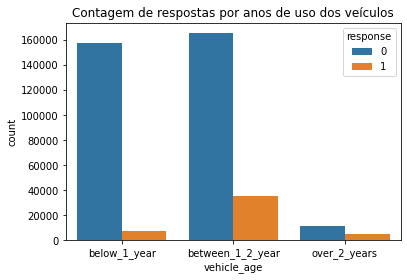

In [191]:
sns.countplot(x=df4['vehicle_age'], hue = df4['response']).set(title='Contagem de respostas por anos de uso dos veículos');

### 4.2.2 A maioria dos usuários que desejam um seguro de saúde são mulheres.
**Falso**. Homens desejam mais seguros que mulheres

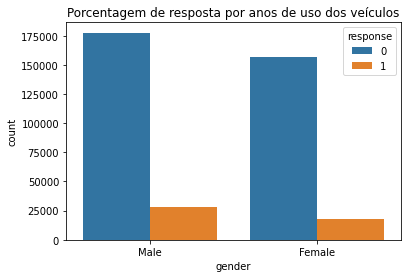

In [192]:
sns.countplot(x=df4['gender'], hue = df4['response']).set(title='Porcentagem de resposta por anos de uso dos veículos');

### 4.2.3 Usuários com idade maior que 40, estão mais interessadas em contratar um seguro.

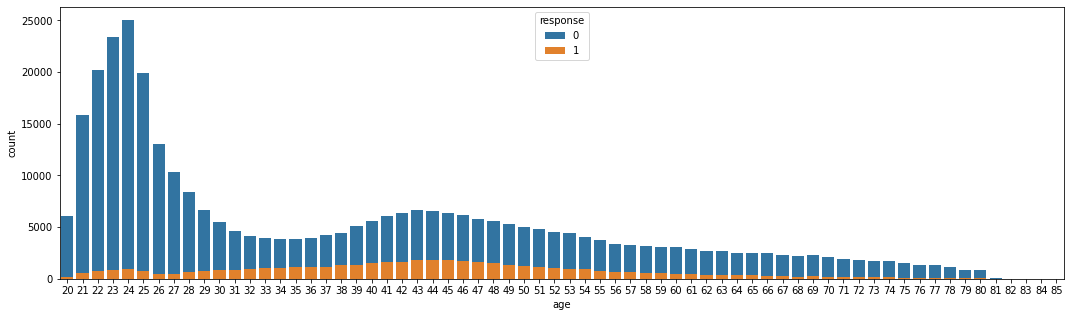

In [193]:
plt.figure(figsize=(18,5))
sns.countplot(x='age', data=df4, hue='response', dodge=False);

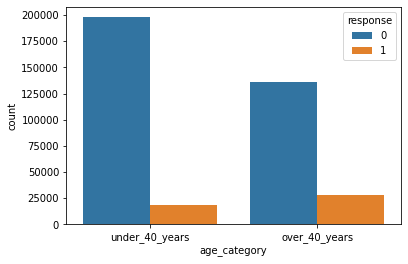

In [194]:
sns.countplot(x=df4['age_category'], hue = df4['response']);

### 4.2.4 A maioria dos usuários que tiveram um acidente veicular não querem seguro de saúde.
**VERDADEIRO**. A maioria dos usuários que sofreram acidentes não querem seguro de saúde.

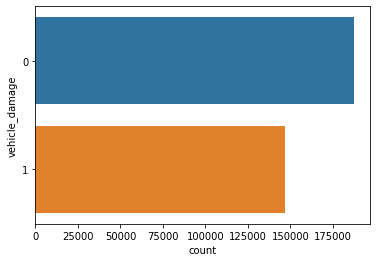

In [195]:
aux1 = df4[(df4['response'] == 0)]
ax = sns.countplot(y='vehicle_damage', data=aux1)
ax=ax

### 4.2.5 Usuários que não possuem habilitação, não estão interessados em contratar um seguro.
**VERDADEIRA** Pessoas sem habilitação não tem interesse em contratar um seguro.

<AxesSubplot:xlabel='driving_license', ylabel='count'>

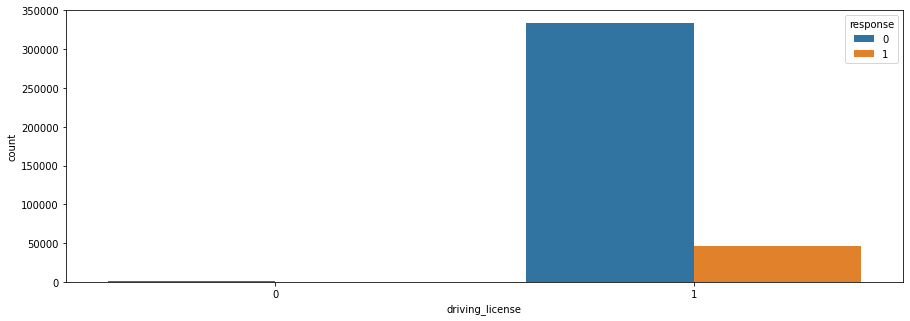

In [196]:
plt.figure(figsize=(15, 5))
sns.countplot(x='driving_license', data=df4, hue='response')

### 4.2.6 Clientes com seguros automotivos são mais propensos a quererem seguro de saúde.
**FALSO**. Pessoas que nunca possuíram seguros automotivos estão mais propensos a quererem seguro de saúde.

<AxesSubplot:xlabel='previously_insured', ylabel='count'>

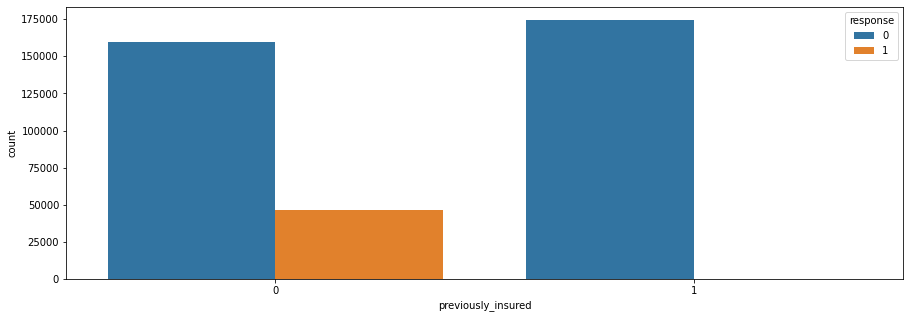

In [197]:
plt.figure(figsize=(15, 5))
sns.countplot(x='previously_insured', data=df4, hue='response')

## 4.3 Análise Multivariada

In [198]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])
num_attributes = num_attributes.drop(columns=['id'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 4.3.1 Numérica

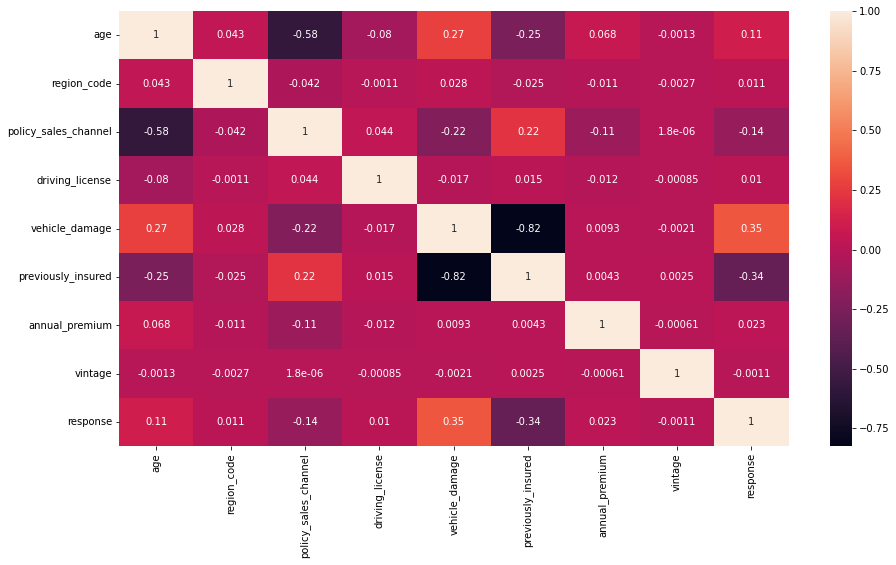

In [199]:
corr = num_attributes.corr()
plt.figure(figsize=(15,8))
ax = sns.heatmap(corr, annot=True)

**Principais pontos:**

- Há uma correlação negativa forte entre os canais de comunicação e a idade do assegurado;
- Há uma leve correlação entre o dano do automóvel e a idade;
- Há uma leve correlação entre o cliente já possuir algum seguro de vida e a quantidade de canais de contato;
- Há uma correlação negativa forte entre o dano do automóvel e se o cliente já possuiu seguro na vida 

### 4.3.2 Categórica

<AxesSubplot:>

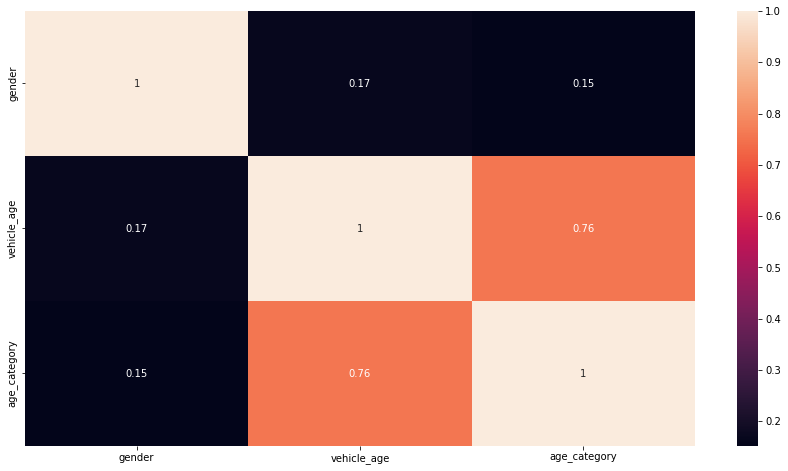

In [200]:
cat_attributes = df4.select_dtypes(include='object')
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = cramer_v(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

**Principais Pontos**:
- Exceto pela idade do veículo e as categorias de idade, não é possível observar nenhuma correlação significativa entre as variáveis.

# 5.0 Data Preparation
---

In [201]:
df5 = df4.copy()

In [202]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [203]:
ss = pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

In [204]:
df5.columns

Index(['gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'id', 'age_category',
       'response'],
      dtype='object')

## 5.2 Rescaling

In [205]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_age.fit_transform(df5[['vintage']].values)

## 5.3 Encoder

In [206]:
# gender - One Hot Encoding / Target Encoding
target_encoding_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encoding_gender)

# region_code - Frequency Enconding / Target Encoding
target_encoding_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encoding_region_code)
# a target encoding nada mais é que a média da variável, também é conhecida como “mean” encoding.

# vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
frequency_encoding_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(frequency_encoding_policy_sales_channel)
# Frequency Encoding está contando quanto cada categoria de policy sales channel tem e dividindo pelo total, 
# é uma frequencia de aparição. Quanto mais vezes ela aparece, maior o peso da categoria para a variável.

# age_category - Label Encoding
df5['age_category'] = df5['age_category'].map({'under_40_years': 0, 'over_40_years': 1})

In [207]:
df5.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,id,age_category,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
256957,0.138984,0.430769,0.105347,0.209707,1,0,1,-0.419153,0.152249,256957,1,0,0,1,0
55155,0.138984,0.615385,0.062523,0.007600,1,1,0,0.281318,0.034602,55155,1,0,0,1,0
256493,0.104070,0.092308,0.073621,0.353321,1,0,1,-0.286887,0.204152,256493,0,0,1,0,0
210981,0.104070,0.030769,0.071053,0.209707,1,0,1,-0.268100,0.529412,210981,0,0,1,0,0
194681,0.104070,0.184615,0.096761,0.015560,1,0,1,0.006841,0.889273,194681,0,0,0,1,0


## 5.4 Validation Preparation

In [208]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:,'gender'].map(target_encoding_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:,'region_code'] = x_validation.loc[:, 'region_code'].map(target_encoding_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:,'policy_sales_channel'] = x_validation['policy_sales_channel'].map(frequency_encoding_policy_sales_channel)

# vintage
x_validation['vintage'] = mms_age.fit_transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0) # tem regiões em region_code que após o target_encoding ficou com NA.

# 6.0 Feature Selection
---

## 6.1 Features Importancia

In [209]:
df6 = df5.copy()

In [210]:
# model definition
extra = en.ExtraTreesClassifier(n_estimators = 50, random_state=42)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
extra.fit(x_train_n, y_train_n)

# dataframe with feature ranking
aux = pd.DataFrame({'features': df6.drop(['id','response'],axis=1).columns,
                    'ExtraTreeClassifier': extra.feature_importances_})
aux

,features,ExtraTreeClassifier
0,gender,0.005554
1,age,0.139187
2,region_code,0.114730
3,policy_sales_channel,0.062921
4,driving_license,0.000446
5,vehicle_damage,0.076381
6,previously_insured,0.051120
7,annual_premium,0.247235
8,vintage,0.277430
9,age_category,0.005013


<AxesSubplot:xlabel='ExtraTreeClassifier', ylabel='features'>

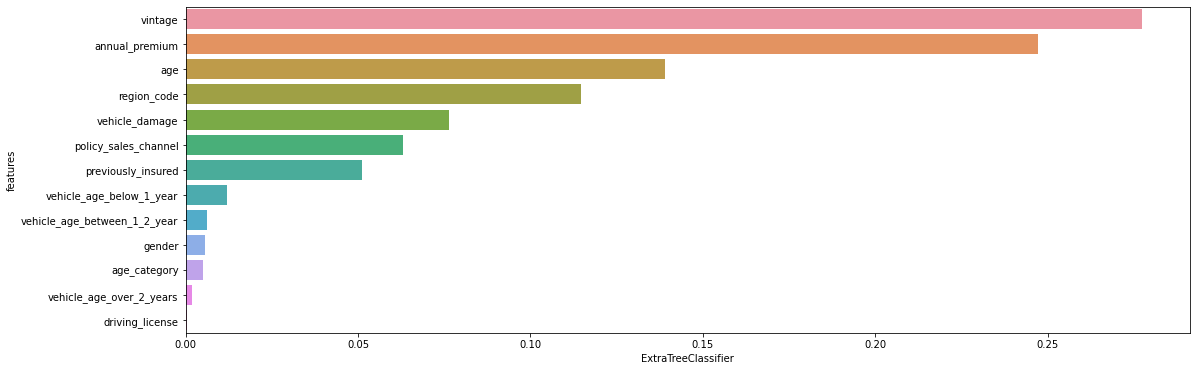

In [211]:
plt.figure(figsize=(18,6))

aux2 = aux.sort_values('ExtraTreeClassifier',ascending = False)
sns.barplot(y='features', x='ExtraTreeClassifier',data = aux2)

In [212]:
importances = extra.feature_importances_
std = np.std([tree.feature_importances_ for tree in extra.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()

for i,j in zip(x_train_n, extra.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

Feature Ranking
                        feature  importance
0                       vintage    0.277430
0                annual_premium    0.247235
0                           age    0.139187
0                   region_code    0.114730
0                vehicle_damage    0.076381
0          policy_sales_channel    0.062921
0            previously_insured    0.051120
0      vehicle_age_below_1_year    0.011904
0  vehicle_age_between_1_2_year    0.006335
0                        gender    0.005554
0                  age_category    0.005013
0      vehicle_age_over_2_years    0.001745
0               driving_license    0.000446


As features que explicam até 5% do fenômeno serão selecionadas aqui. 

## 6.2 Features Selected

In [213]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# 7.0 Machine Learning Model
---

In [214]:
x_validation.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,id,age_category,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
229755,0.104070,0.193772,0.079228,0.353321,1,0,1,0.051841,0.474048,229755,over_40_years,0,1,0
132896,0.138984,0.155709,0.187638,0.209707,1,1,0,1.670448,0.062284,132896,over_40_years,0,0,1
5266,0.138984,0.128028,0.062523,0.194574,1,1,0,1.105991,0.643599,5266,over_40_years,0,1,0
32084,0.138984,0.058824,0.121416,0.353321,1,0,1,-0.026913,0.726644,32084,under_40_years,1,0,0
97772,0.104070,0.155709,0.187638,0.026010,1,0,1,0.715173,0.958478,97772,over_40_years,0,1,0


In [215]:
x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1 KNN

In [216]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Poder de GENERALIZACAO
yhat_knn = knn_model.predict_proba(x_val)

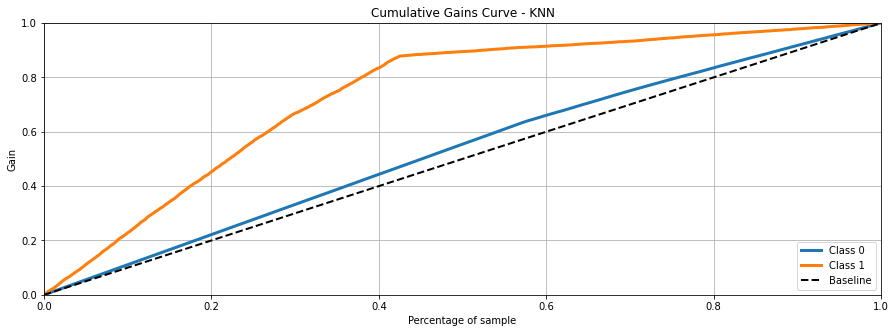

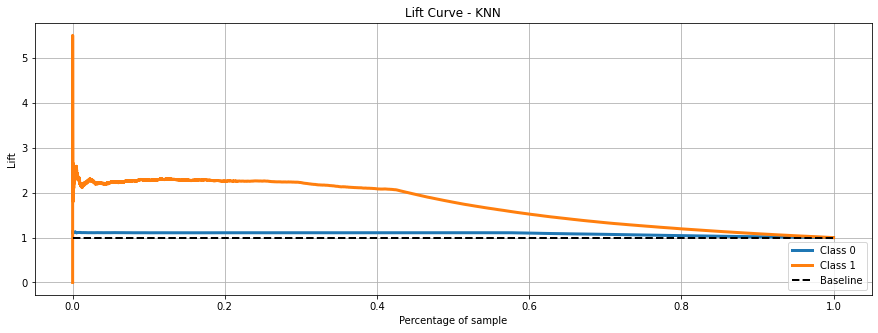

In [217]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, figsize=(15, 5), title='Cumulative Gains Curve - KNN');
skplt.metrics.plot_lift_curve(y_val, yhat_knn, figsize=(15, 5), title='Lift Curve - KNN');

Este gráfico indica que se pegar o usuário, do dado de teste e calcular a probabilidade dele e olhar o primeiro usuário, definir se ele compraria ou não e fazer o acumulado disso, o plot é esta curva laranja. Abordando 20% da lista ordenada, alcançara 50% das pessoas interessadas. Quanto mais o modelo melhora, mais pessoas são atingidas na mesma porcentagem.

Em suma, se houver uma lista com 100 pessoas, ligando para as 20 primeiras, existe uma chance de 60% de todos quererem o produto.

## 7.2 Logistic Regression

In [218]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction - Poder de GENERALIZACAO
yhat_lr = lr_model.predict_proba(x_val)

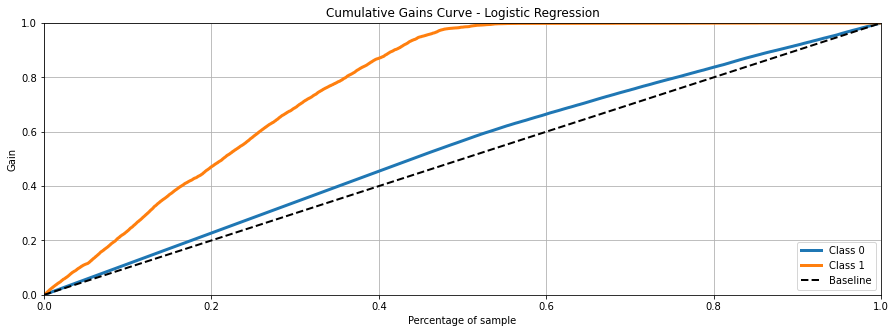

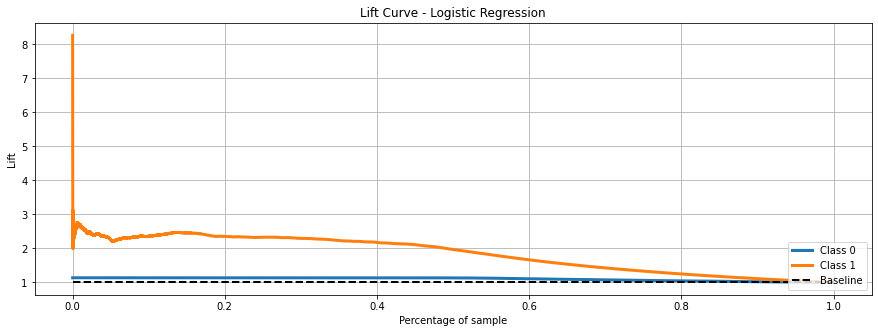

In [219]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, figsize=(15, 5), title='Cumulative Gains Curve - Logistic Regression');
skplt.metrics.plot_lift_curve(y_val, yhat_lr, figsize=(15, 5), title='Lift Curve - Logistic Regression');

Então, em torno de 50% dos clientes abordados será selecionado 100% das pessoas que se interessam pelo produto. Assim, diminui-se o custo, uma vez que quanto maior a porcentagem da amostra, maior o custo. 

## 7.3 Extra Tree

In [220]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators = 1000, n_jobs=-1, random_state=42)

# model fit
et_model.fit(x_train,y_train)

# model predict
yhat_et = et_model.predict_proba(x_val)

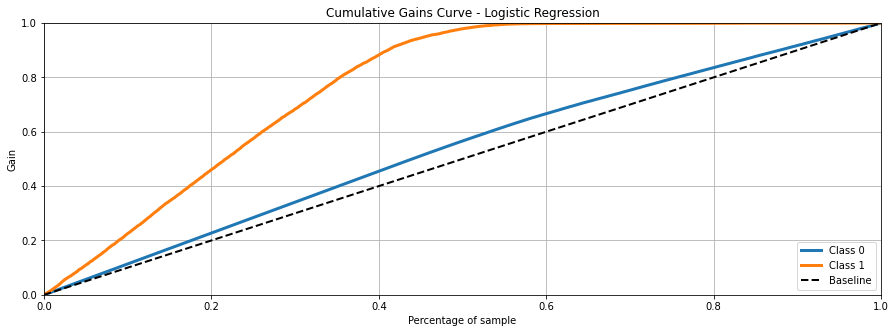

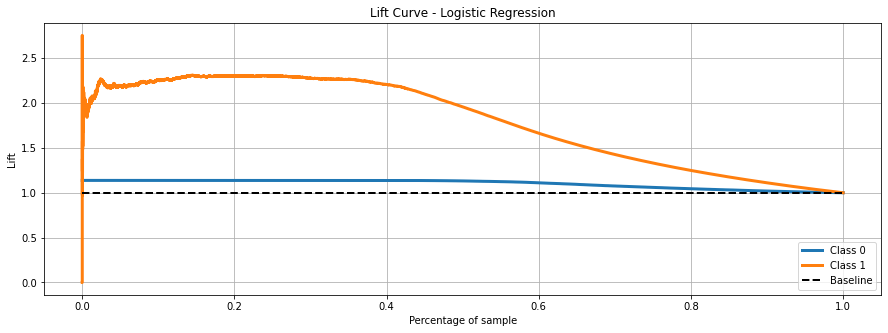

In [221]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, figsize=(15, 5), title='Cumulative Gains Curve - Logistic Regression');
skplt.metrics.plot_lift_curve(y_val, yhat_et, figsize=(15, 5), title='Lift Curve - Logistic Regression');

## 7.4 XGBoost

In [222]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators=11, max_depth=7)

# XGB training
xgb_model.fit(x_train,y_train)

# XGB prediction - Generalization
yhat_xgb = xgb_model.predict_proba(x_val)

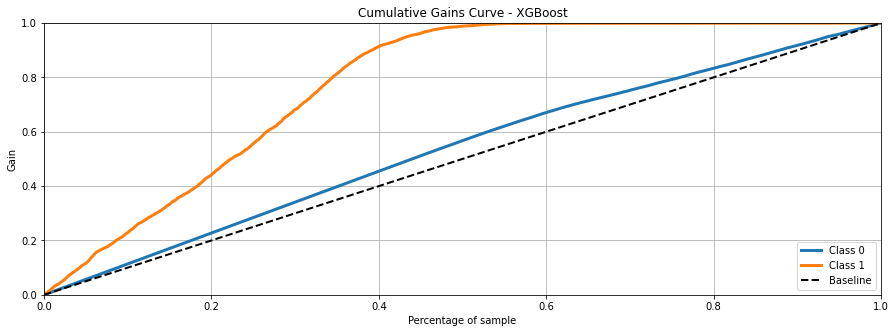

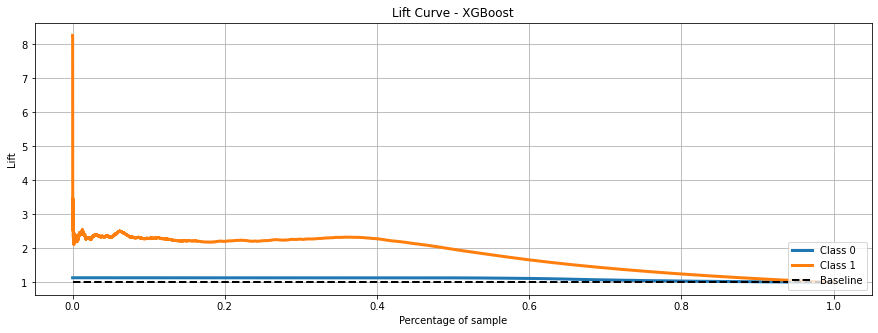

In [223]:
# Accumulative gain - XGB
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, figsize=(15, 5), title='Cumulative Gains Curve - XGBoost')
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, figsize=(15, 5), title='Lift Curve - XGBoost');

## 7.5 AdaBoost

In [224]:
# model definition
ada_model = en.AdaBoostClassifier(random_state=42)

# Ada training
ada_model.fit(x_train,y_train)

# Ada prediction - Generalization
yhat_ada = ada_model.predict_proba(x_val)

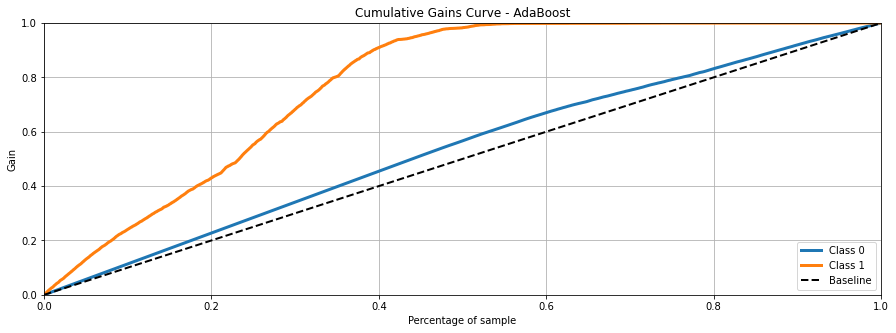

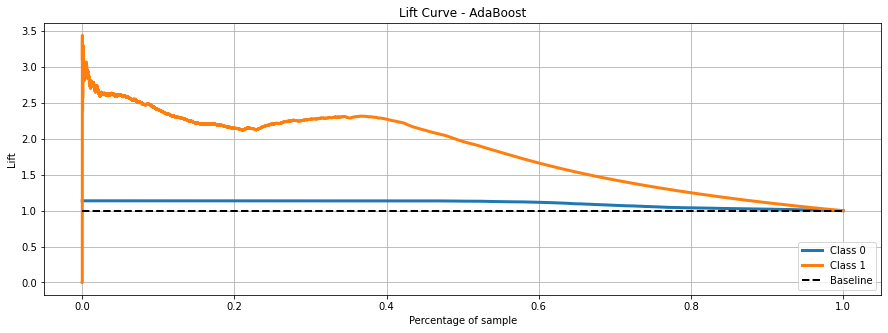

In [225]:
# Accumulative gain - XGB
skplt.metrics.plot_cumulative_gain(y_val, yhat_ada, figsize=(15, 5), title='Cumulative Gains Curve - AdaBoost')
skplt.metrics.plot_lift_curve(y_val, yhat_ada, figsize=(15, 5), title='Lift Curve - AdaBoost');

## 7.6 CrossValidation 

In [226]:
knn_model = nh.KNeighborsClassifier(n_neighbors=8)
lr_model  = lm.LogisticRegression(random_state=42)
et_model = en.ExtraTreesClassifier(n_estimators = 1000, n_jobs=-1, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=11, max_depth=7)
ada_model  = en.AdaBoostClassifier(random_state=42)

models_dict = {'KNN': knn_model,
              'Logistic_Regression': lr_model,
              'Extra Trees': et_model,
              'XG Boost': xgb_model,
              'AdaBoost':ada_model}

In [227]:
cv_dict = {'Mean Precision @k':[], 'STD Precision @k':[], 'Mean Recall @k': [], 'STD Recall @k':[]}
indexes = []

kfolds = 6
at_ks=20000

for name, model in models_dict.items():
    
    print(f'Cross validation for model: {name}')
    model_metric = list(cross_validation(kfold=kfolds,
                        at_k=at_ks,
                        model=model,
                        data=df6,
                        target='response',
                        cols_selected=cols_selected))
    
    indexes.append(name)
    cv_dict['Mean Precision @k'].append(model_metric[0])
    cv_dict['STD Precision @k'].append(model_metric[1])
    cv_dict['Mean Recall @k'].append(model_metric[2])
    cv_dict['STD Recall @k'].append(model_metric[3])

result = pd.DataFrame(cv_dict,index=indexes)
result

Cross validation for model: KNN
Cross validation for model: Logistic_Regression
Cross validation for model: Extra Trees
Cross validation for model: XG Boost
Cross validation for model: AdaBoost


,Mean Precision @k,STD Precision @k,Mean Recall @k,STD Recall @k
KNN,0.264878,0.001463,0.847947,0.004657
Logistic_Regression,0.269403,0.001499,0.862432,0.004775
Extra Trees,0.273020,0.001209,0.874009,0.003823
XG Boost,0.285577,0.001399,0.914210,0.004443
AdaBoost,0.285036,0.001132,0.912476,0.003583


O algoritmo escolhido foi o XG Boost (Reall: 91,62%)

# 8.0 Hyperparameter Fine Tunning
---

In [228]:
df8 = df6.copy()

In [229]:
param = {
    'n_estimators': [150,170,250,300,350],
    'eta': [0.01,0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }
MAX_EVAL = 10

In [230]:
model_xgb_hyperparameter = xgb.XGBClassifier(base_estimator=tr.DecisionTreeClassifier(),random_state=42)
hft = ms.RandomizedSearchCV(model_xgb_hyperparameter,param,verbose=3,n_iter=10,scoring='recall',random_state=42)

In [231]:
#hft.fit(x_train,y_train)

In [232]:
#hft.best_params_

In [233]:
param_tuned = {'subsample': 0.5,
 'n_estimators': 350,
 'min_child_weight': 15,
 'max_depth': 9,
 'eta': 0.03,
 'colsample_bytree': 0.7}

## 8.1 Final Model

In [234]:
xgb_model_tunned = xgb.XGBClassifier(subsample=0.5, 
                                     n_estimators=350, 
                                     min_child_weight=15,
                                     max_depth=9, 
                                     eta=0.03, 
                                     colsample_bytree=0.7)

# XGB training
xgb_model_tunned.fit(x_train,y_train)

# XGB prediction - Generalization
yhat_xgb_model_tunned = xgb_model_tunned.predict_proba(x_val)

# 9.0 Model Performance
---

In [235]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_xgb_model_tunned[:,1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score', ascending=False)

# reset index
df8 = df8.reset_index()

# creating ranking order
df8['ranking'] = df8.index+1

df8['precision_at_k'] = df8['response'].cumsum() / df8['ranking']

# compute precision at k
precision_at_50 = precision_at_k(df8,k=50)
print(f'Pecision at K: {precision_at_50}')

recall_at_50 = recall_at_k(df8,k=50)
print(f'Recall at K: {recall_at_50}')

Pecision at K: 0.2549019607843137
Recall at K: 0.0014095196790632116


# 10.0 Final list with ranking
---

In [236]:
df_raw = df_raw.iloc[df8['index']]
# reset index
df_raw = df_raw.reset_index(drop=True)

# creating ranking order
df_raw['ranking'] = df_raw.index+1

In [237]:
df_raw.head(10)

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,id,ranking
0,Male,67,35.0,26.0,1,1-2 Year,Yes,0,18691.0,221,0,276601,1
1,Male,51,29.0,124.0,1,1-2 Year,Yes,0,22281.0,17,0,27183,2
2,Male,48,29.0,124.0,1,1-2 Year,Yes,0,29255.0,36,1,232210,3
3,Male,72,3.0,124.0,1,1-2 Year,Yes,0,18610.0,32,0,267463,4
4,Female,57,3.0,163.0,1,1-2 Year,Yes,0,18638.0,226,1,215543,5
5,Male,70,29.0,26.0,1,1-2 Year,Yes,0,29290.0,63,0,288942,6
6,Male,59,6.0,124.0,1,1-2 Year,Yes,0,29158.0,11,1,122463,7
7,Male,48,35.0,124.0,1,1-2 Year,Yes,0,21870.0,203,1,262207,8
8,Male,49,29.0,26.0,1,1-2 Year,Yes,0,25065.0,69,0,324912,9
9,Male,59,29.0,26.0,1,1-2 Year,Yes,0,27446.0,13,0,331471,10
